First I will load my dataset, im going to be chaning the names so there is no mixup between mine and Kalinas

✅ RNA Filtered shape: (17535, 29)


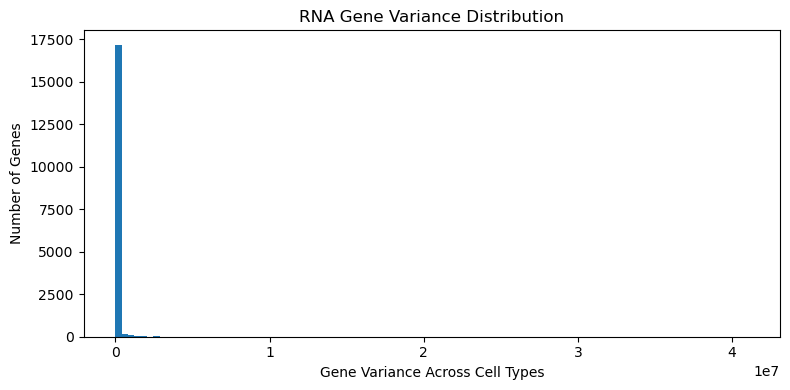

🔹 Original shape: (17535, 29)
🔹 After RNA variance filtering: (8494, 29)


In [2]:
# Step 1: Load dataset
import pandas as pd

rna_df = pd.read_csv("raw datasets/mmc2.csv", index_col=0)

# Step 2: Keep only selected cell types
rna_cell_types_to_keep = [
    "preT.DN1.Th", "preT.DN2a.Th", "preT.DN2b.Th", "preT.DN3.Th",
    "T.DN4.Th", "T.ISP.Th", "T.DP.Th", "T.4.Th", "T.8.Th",
    "T.4.Nve.Sp", "T.4.Nve.Fem.Sp", "T.4.Sp.aCD3+CD40.18hr", "T.8.Nve.Sp",
    "Treg.4.25hi.Sp", "Treg.4.FP3+.Nrplo.Co",
    "T8.TN.P14.Sp", "T8.TE.LCMV.d7.Sp", "T8.MP.LCMV.d7.Sp", "T8.IEL.LCMV.d7.Gut",
    "T8.Tcm.LCMV.d180.Sp", "T8.Tem.LCMV.d180.Sp",
    "NKT.Sp", "NKT.Sp.LPS.3hr", "NKT.Sp.LPS.18hr", "NKT.Sp.LPS.3d",
    "LTHSC.34-.BM", "LTHSC.34+.BM", "STHSC.150-.BM", "MPP4.135+.BM"
]

rna_filtered_df = rna_df[rna_cell_types_to_keep]
rna_filtered_df.to_csv("rna_filtered_abT_Tact_Stem.csv")
print("✅ RNA Filtered shape:", rna_filtered_df.shape)

# Step 3: Plot gene variance distribution
import matplotlib.pyplot as plt

rna_gene_variances = rna_filtered_df.var(axis=1)

plt.figure(figsize=(8, 4))
plt.hist(rna_gene_variances, bins=100)
plt.xlabel("Gene Variance Across Cell Types")
plt.ylabel("Number of Genes")
plt.title("RNA Gene Variance Distribution")
plt.tight_layout()
plt.show()


# Step 4: Filter genes with high variance
rna_var_threshold = 500
rna_high_var_genes = rna_gene_variances[rna_gene_variances > rna_var_threshold].index
rna_refined_df = rna_filtered_df.loc[rna_high_var_genes]

print(f"🔹 Original shape: {rna_filtered_df.shape}")
print(f"🔹 After RNA variance filtering: {rna_refined_df.shape}")




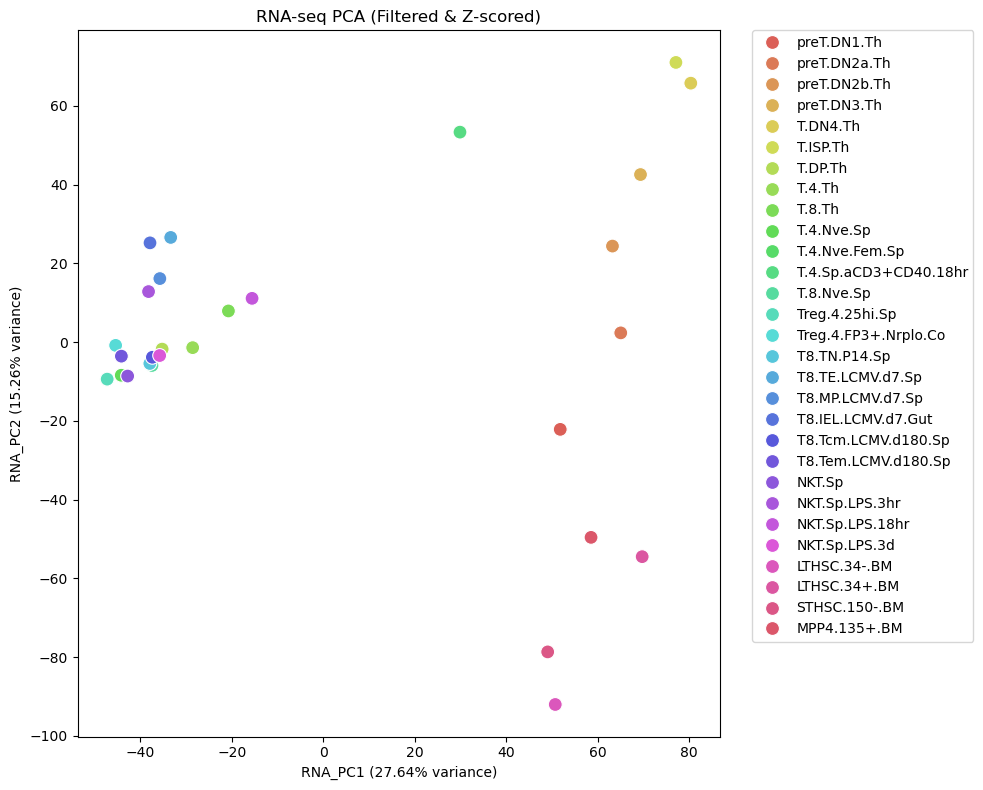

In [3]:
# Step 5: Transpose and scale (Z-score)
from sklearn.preprocessing import StandardScaler

rna_transposed_df = rna_refined_df.T  # rows = samples (cell types), columns = features (genes)

rna_scaler = StandardScaler()
rna_scaled_array = rna_scaler.fit_transform(rna_transposed_df)

# Back to DataFrame
rna_scaled_df = pd.DataFrame(rna_scaled_array, index=rna_transposed_df.index, columns=rna_transposed_df.columns)
rna_scaled_df.head()
# Step 6: PCA
from sklearn.decomposition import PCA

rna_pca_model = PCA(n_components=2)
rna_pca_result = rna_pca_model.fit_transform(rna_scaled_df)
# Step 7: Plot PCA
import seaborn as sns

rna_pca_df = pd.DataFrame(rna_pca_result, columns=["RNA_PC1", "RNA_PC2"], index=rna_scaled_df.index)
rna_pca_df["RNA_CellType"] = rna_pca_df.index

plt.figure(figsize=(10, 8))
sns.scatterplot(
    data=rna_pca_df,
    x="RNA_PC1",
    y="RNA_PC2",
    hue="RNA_CellType",
    palette=sns.color_palette("hls", n_colors=rna_pca_df["RNA_CellType"].nunique()),
    s=100
)

plt.xlabel(f"RNA_PC1 ({rna_pca_model.explained_variance_ratio_[0] * 100:.2f}% variance)")
plt.ylabel(f"RNA_PC2 ({rna_pca_model.explained_variance_ratio_[1] * 100:.2f}% variance)")
plt.title("RNA-seq PCA (Filtered & Z-scored)")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.tight_layout()
plt.show()



Now I will be loading Kalinas dataset and rename hers

✅ ATAC matrix shape: (512595, 29)


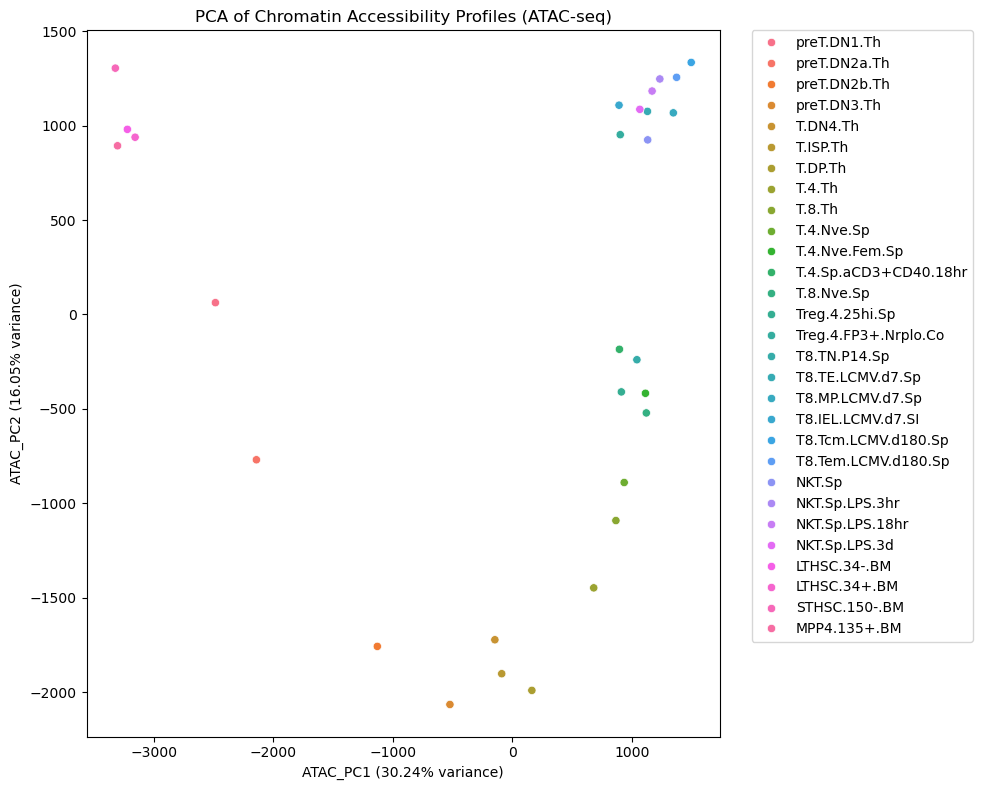

In [4]:
# Step 1: Load ATAC-seq signal matrix
import pandas as pd

atac_peak_matrix = pd.read_csv("ATAC-seq/filtered_ATAC_abT_Tact_Stem.csv")
atac_signal_matrix = atac_peak_matrix.iloc[:, 8:]  # drop metadata columns if any
print("✅ ATAC matrix shape:", atac_signal_matrix.shape)
atac_signal_matrix.head()
# Step 2: Transpose so that rows = samples (cell types), columns = features
atac_transposed_df = atac_signal_matrix.T
atac_transposed_df.head()
# Step 3: PCA on ATAC-seq
from sklearn.decomposition import PCA

atac_pca_model = PCA(n_components=2)
atac_pca_result = atac_pca_model.fit_transform(atac_transposed_df)

# Put into DataFrame
atac_pca_df = pd.DataFrame(atac_pca_result, columns=["ATAC_PC1", "ATAC_PC2"], index=atac_transposed_df.index)
atac_pca_df.head()
# Step 4: Plot ATAC PCA
import seaborn as sns
import matplotlib.pyplot as plt

# Reset index so CellType is a column, not an index
atac_pca_df = atac_pca_df.reset_index().rename(columns={"index": "ATAC_CellType"})

plt.figure(figsize=(10, 8))
sns.scatterplot(
    data=atac_pca_df,
    x="ATAC_PC1",
    y="ATAC_PC2",
    hue="ATAC_CellType"
)

plt.xlabel(f"ATAC_PC1 ({atac_pca_model.explained_variance_ratio_[0] * 100:.2f}% variance)")
plt.ylabel(f"ATAC_PC2 ({atac_pca_model.explained_variance_ratio_[1] * 100:.2f}% variance)")
plt.title("PCA of Chromatin Accessibility Profiles (ATAC-seq)")
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left", borderaxespad=0.)
plt.tight_layout()
plt.show()




In [5]:
rna_celltypes = set(rna_pca_df["RNA_CellType"].unique())
atac_celltypes = set(atac_pca_df["ATAC_CellType"].unique())

common = sorted(rna_celltypes & atac_celltypes)
only_in_rna = sorted(rna_celltypes - atac_celltypes)
only_in_atac = sorted(atac_celltypes - rna_celltypes)

print("✅ Common cell types:", common)
print("\n❌ Only in RNA PCA:", only_in_rna)
print("\n❌ Only in ATAC PCA:", only_in_atac)


✅ Common cell types: ['LTHSC.34+.BM', 'LTHSC.34-.BM', 'MPP4.135+.BM', 'NKT.Sp', 'NKT.Sp.LPS.18hr', 'NKT.Sp.LPS.3d', 'NKT.Sp.LPS.3hr', 'STHSC.150-.BM', 'T.4.Nve.Fem.Sp', 'T.4.Nve.Sp', 'T.4.Sp.aCD3+CD40.18hr', 'T.4.Th', 'T.8.Nve.Sp', 'T.8.Th', 'T.DN4.Th', 'T.DP.Th', 'T.ISP.Th', 'T8.MP.LCMV.d7.Sp', 'T8.TE.LCMV.d7.Sp', 'T8.TN.P14.Sp', 'T8.Tcm.LCMV.d180.Sp', 'T8.Tem.LCMV.d180.Sp', 'Treg.4.25hi.Sp', 'Treg.4.FP3+.Nrplo.Co', 'preT.DN1.Th', 'preT.DN2a.Th', 'preT.DN2b.Th', 'preT.DN3.Th']

❌ Only in RNA PCA: ['T8.IEL.LCMV.d7.Gut']

❌ Only in ATAC PCA: ['T8.IEL.LCMV.d7.SI']


So here we see that not all cell types have the same name. But this actually is the same cell type just named differently. We are going to fix this.


In [6]:
rna_pca_df["RNA_CellType"] = rna_pca_df["RNA_CellType"].replace("T8.IEL.LCMV.d7.Gut", "T8.IEL.LCMV.d7.SI")


In [7]:
rna_pca_plot_df = rna_pca_df.set_index("RNA_CellType")
atac_pca_plot_df = atac_pca_df.set_index("ATAC_CellType")


In [8]:
# Set cell type as index for both
rna_pca_plot_df = rna_pca_df.set_index("RNA_CellType")
atac_pca_plot_df = atac_pca_df.set_index("ATAC_CellType")

# Just in case, reorder RNA to match ATAC
rna_pca_plot_df = rna_pca_plot_df.loc[atac_pca_plot_df.index]


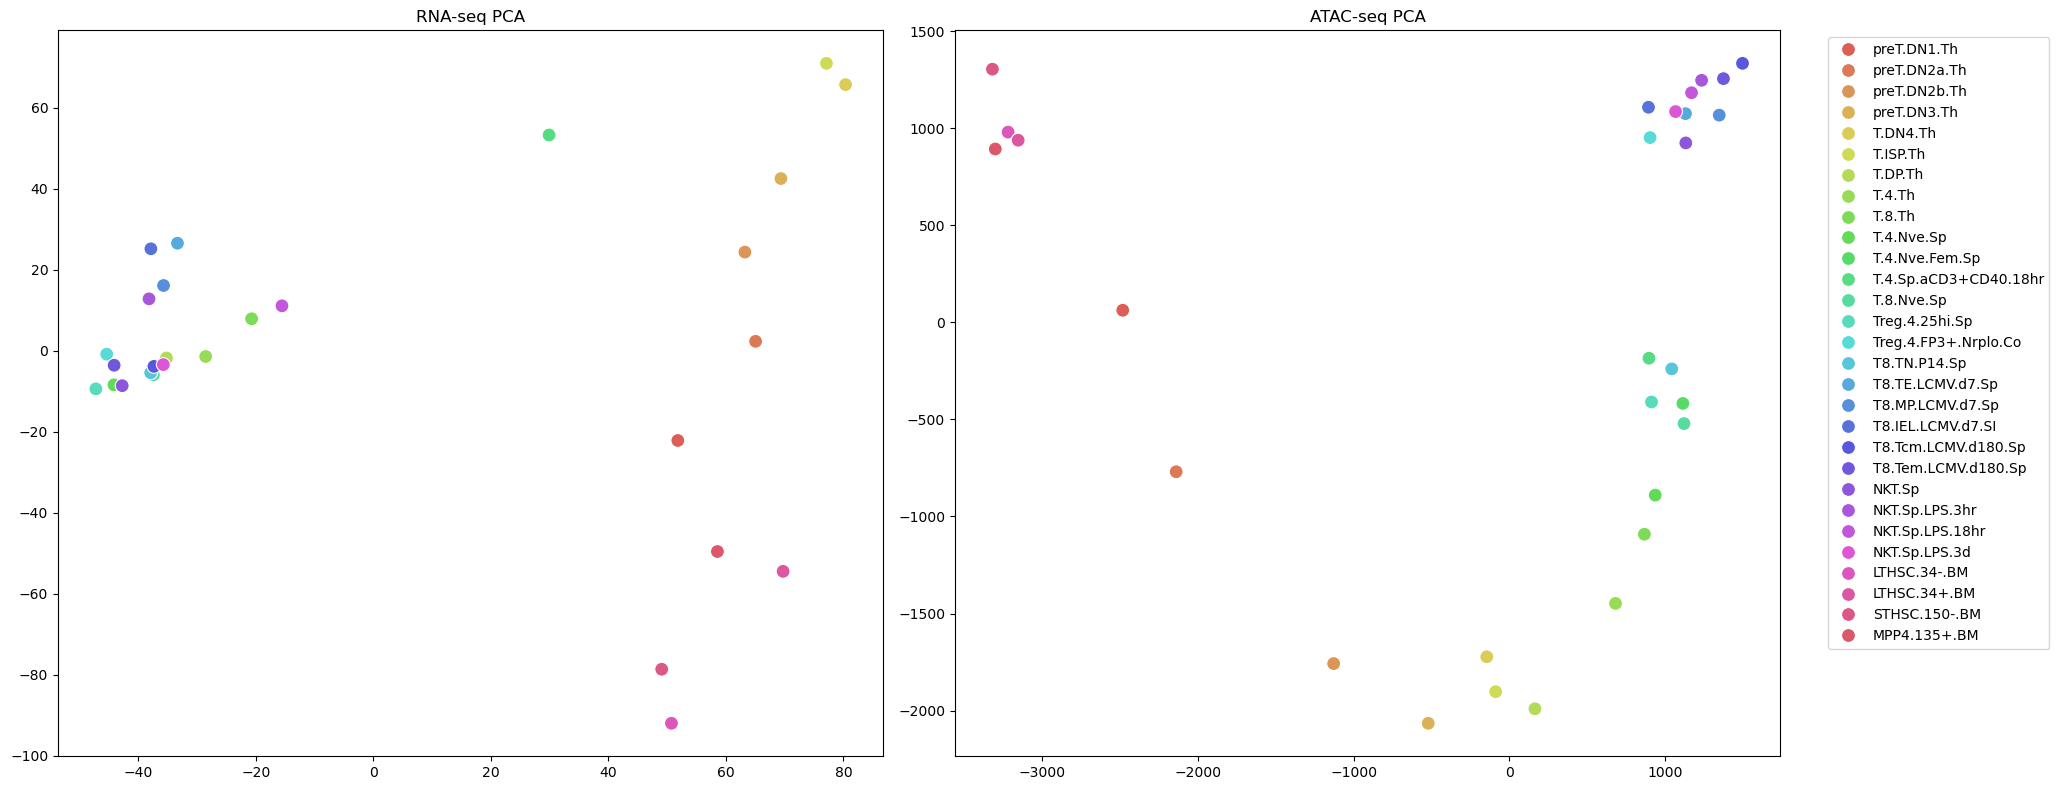

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Reset both and unify the CellType column name
rna_plot_df = rna_pca_df.rename(columns={"RNA_CellType": "CellType"})
atac_plot_df = atac_pca_df.rename(columns={"ATAC_CellType": "CellType"})

# Step 2: Create a shared color palette
shared_palette = dict(zip(
    rna_plot_df["CellType"],
    sns.color_palette("hls", len(rna_plot_df))
))

# Step 3: Plot side-by-side PCA results
fig, axes = plt.subplots(1, 2, figsize=(18, 8))

# RNA PCA
sns.scatterplot(
    data=rna_plot_df,
    x="RNA_PC1", y="RNA_PC2", hue="CellType",
    palette=shared_palette, ax=axes[0], s=100
)
axes[0].set_title("RNA-seq PCA")
axes[0].legend().remove()

# ATAC PCA
sns.scatterplot(
    data=atac_plot_df,
    x="ATAC_PC1", y="ATAC_PC2", hue="CellType",
    palette=shared_palette, ax=axes[1], s=100
)
axes[1].set_title("ATAC-seq PCA")
axes[1].legend().remove()

# Final touches
for ax in axes:
    ax.set_xlabel("")
    ax.set_ylabel("")

plt.tight_layout()
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


In [10]:
from sklearn.cluster import KMeans

# Cluster both into same number of groups
n_clusters = 5
rna_clusters = KMeans(n_clusters=n_clusters, random_state=42).fit_predict(rna_pca_plot_df)
atac_clusters = KMeans(n_clusters=n_clusters, random_state=42).fit_predict(atac_pca_plot_df)


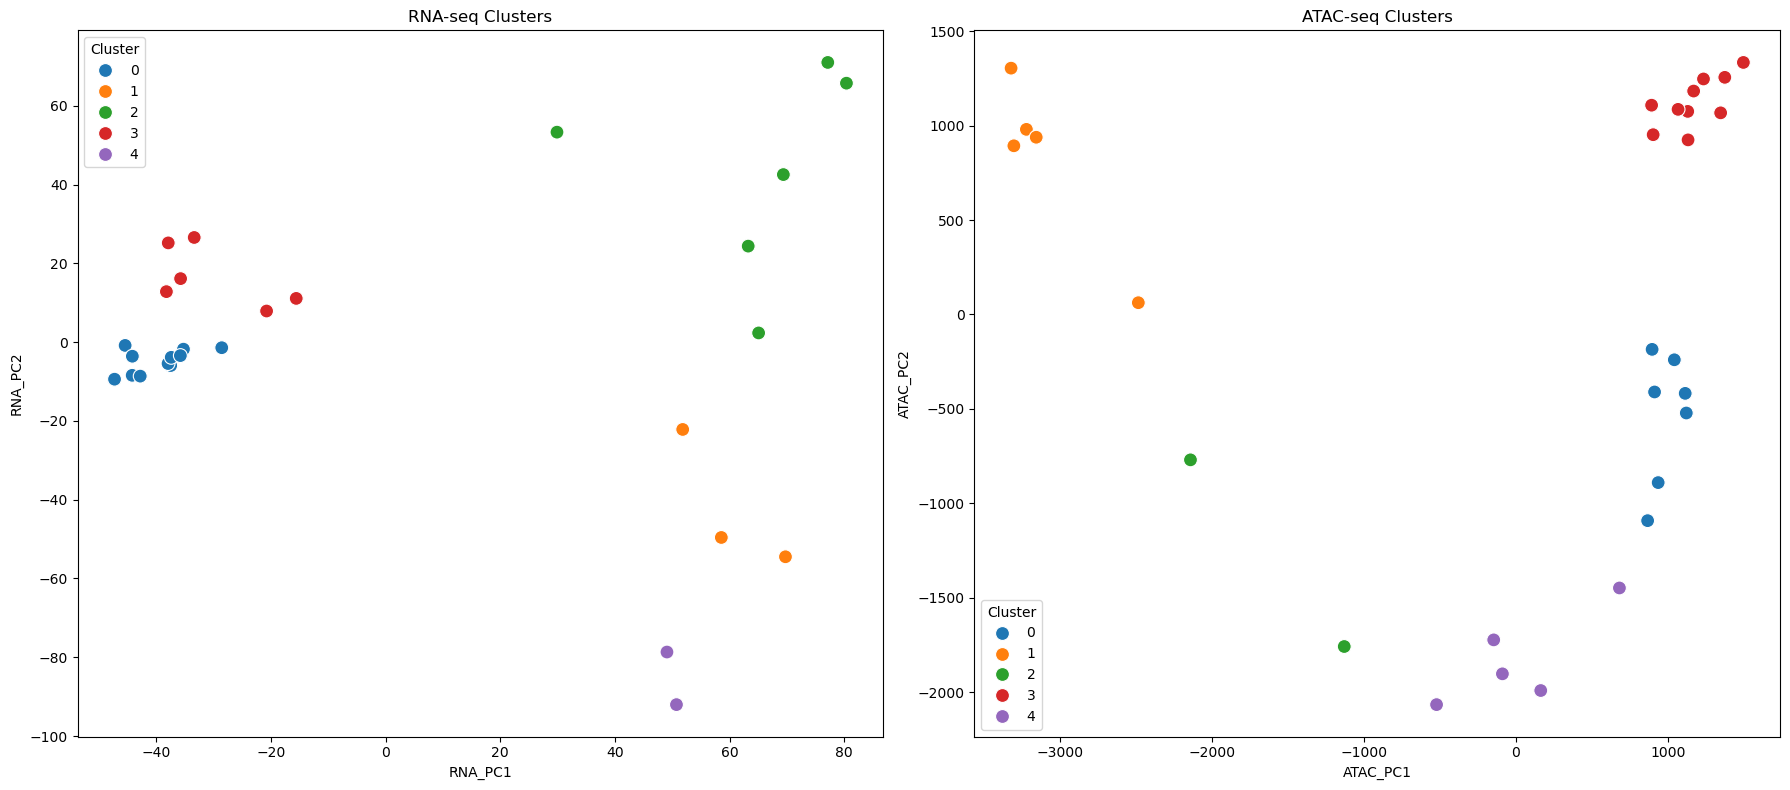

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Attach clusters for plotting
rna_plot_df["Cluster"] = rna_clusters
atac_plot_df["Cluster"] = atac_clusters

fig, axes = plt.subplots(1, 2, figsize=(18, 8))

# RNA clusters
sns.scatterplot(data=rna_plot_df, x="RNA_PC1", y="RNA_PC2", hue="Cluster", palette="tab10", ax=axes[0], s=100)
axes[0].set_title("RNA-seq Clusters")

# ATAC clusters
sns.scatterplot(data=atac_plot_df, x="ATAC_PC1", y="ATAC_PC2", hue="Cluster", palette="tab10", ax=axes[1], s=100)
axes[1].set_title("ATAC-seq Clusters")

plt.tight_layout()
plt.show()


In [14]:
from sklearn.metrics import adjusted_rand_score

ari_score = adjusted_rand_score(rna_clusters, atac_clusters)
print(f"🔁 Adjusted Rand Index (RNA vs ATAC clustering): {ari_score:.3f}")


🔁 Adjusted Rand Index (RNA vs ATAC clustering): 0.244


The ARI score of 0.244 indicates a modest overlap between RNA-seq and ATAC-seq cluster structures — meaning some agreement in how cell types are grouped, but also significant differences in the way expression and accessibility define clusters.

/opt/miniconda3/envs/REAL_FORKED_Bioinfo_project/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


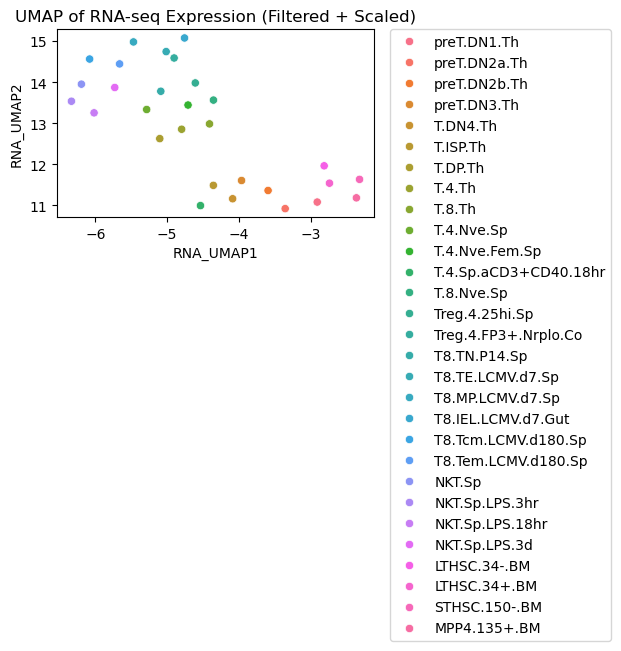

In [15]:
import umap.umap_ as umap
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Run UMAP on scaled RNA expression (cell types as rows)
rna_umap_model = umap.UMAP(n_components=2, random_state=42)
rna_umap_result = rna_umap_model.fit_transform(rna_scaled_df)

# Make a DataFrame
rna_umap_df = pd.DataFrame(
    rna_umap_result,
    columns=["RNA_UMAP1", "RNA_UMAP2"],
    index=rna_scaled_df.index
)

# Add CellType column for plotting
rna_umap_df["RNA_CellType"] = rna_umap_df.index

# Plot
rna_umap_df = rna_umap_df.reset_index(drop=True)
sns.scatterplot(
    data=rna_umap_df,
    x="RNA_UMAP1", y="RNA_UMAP2", hue="RNA_CellType"
)
plt.title("UMAP of RNA-seq Expression (Filtered + Scaled)")
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left", borderaxespad=0.)
plt.tight_layout()
plt.show()
